# `lipyd`: a Python module for lipidomics LC MS/MS data analysis

### 1: Chemical calculator

In [14]:
import imp
from lipyd import mass
from lipyd import formula
imp.reload(mass)
imp.reload(formula)

<module 'lipyd.formula' from '/home/denes/Dokumentumok/lipyd/src/lipyd/formula.py'>

The `mass` module knows exact masses of isotopes, isotopic abundances, weights, etc. The `MassBase` class is able to process chemical formula, calculate masses and do arithmetics.

In [4]:
mass.get_mass('Na')

22.989769282

In [6]:
mass.MassBase('C2H6') - mass.MassBase('H') + mass.MassBase('OH')

46.04186481376

Expression evaluation with `mass.expr`:

In [8]:
mass.expr('C2H6 - H + OH')

46.04186481376

In [9]:
mass.expr('C6H12O6 - water')

162.0528234236

Make a deuterium:

In [11]:
mass.expr('H + n')

2.0164899481400003

Hydrogensulphate ion:

In [12]:
mass.expr('HSO4 + e')

96.96010326786924

Additional attributes can be provided in keyword arguments to carry metadata.

In [40]:
lactic_acid = formula.Formula('CH3CHOHCOOH', name = 'lactic acid')
lactic_acid.attrs.name

'lactic acid'

A galactose:

In [15]:
((2 * formula.Formula('C6H12O6')) - 'H2O').formula

'C12H22O11'

### 2: Calculations with adducts

In [16]:
from lipyd import mz

This is an oleic acid. What is the mass of the [M-H]- adduct?

In [17]:
formula.Formula('C18H34O2').remove_h()

281.24860387047

We have seen a mass and wondering what is the exact mass if it is an [M+NH4]+ adduct:

In [22]:
mz.Mz(854.576482597791).remove_nh4()

836.5426570444603

Calculate the [M+Li]+ adduct for the same molecule:

In [24]:
mz.Mz(836.5426570444603).adduct(mass.MassBase('Li', charge = 1))

843.558111907551

### 3: Metabolite model

Metabolites consist of a core and optionally substituents. Substituents might be formulas or moieties with aliphatic chains.

In [35]:
from lipyd import metabolite
from lipyd import substituent
imp.reload(metabolite)
imp.reload(substituent)

<module 'lipyd.substituent' from '/home/denes/Dokumentumok/lipyd/src/lipyd/substituent.py'>

Make all combinations of halogenated methanes:

In [28]:
halo_methanes = metabolite.AbstractMetabolite(core = 'C', subs = [('H', 'F', 'Cl', 'Br', 'I')] * 4)

Check the first 3:

In [30]:
[(m.formula, m.mass) for m in halo_methanes][:3]

[('C1H4', 16.031300129039998),
 ('C1F1H3', 34.02187826038),
 ('C1Cl1H3', 49.99232782678)]

Do the same with all alcohols up to 1-8 carbon count with 0-2 unsaturated bonds:

In [34]:
chain = metabolite.AbstractSubstituent(c = (1, 8), u = (0, 2))
alcohols = metabolite.AbstractMetabolite(subs = (chain, ('OH',)))
[(m.formula, m.mass) for m in alcohols][:3]

[('C1H4O1', 32.02621474924),
 ('C2H6O1', 46.04186481376),
 ('C3H8O1', 60.057514878279996)]

Make some ceramides:

In [39]:
# fatty acyls of length 16, 18 or 20 and one or no unsaturation:
fattyacyl = substituent.FattyAcyl(c = (16, 18, 20), u = (0, 1))
lcb = substituent.Sphingosine(c = 18, u = 1)
ceramides = metabolite.AbstractMetabolite(core = 'H', subs = (lcb, fattyacyl), name = 'Cer')
# name, formula, mass, [M+H]+, [M+NH4]+
[(cer.name, cer.formula, cer.mass, cer.add_nh4()) for cer in ceramides]

[('Cer(18:1/16:0)', 'C34H67N1O3', 537.51209502622, 555.5459205795507),
 ('Cer(18:1/16:1)', 'C34H65N1O3', 535.4964449617, 553.5302705150308),
 ('Cer(18:1/18:0)', 'C36H71N1O3', 565.54339515526, 583.5772207085907),
 ('Cer(18:1/18:1)', 'C36H69N1O3', 563.52774509074, 581.5615706440708),
 ('Cer(18:1/20:0)', 'C38H75N1O3', 593.5746952843, 611.6085208376307),
 ('Cer(18:1/20:1)', 'C38H73N1O3', 591.55904521978, 609.5928707731108)]

### 2: Metabolite database

In [1]:
from lipyd import moldb
imp.reload(moldb)

db = moldb.MoleculeDatabaseAggregator()

        Indexing SwissLipids -- finished: 100%|██████████| 623M/623M [00:15<00:00, 39.8Mit/s]


	:: Indexed 42556 records from `cache/LMSDFDownload12Dec17FinalAll.sdf`.


        Generating metabolites -- finished: 100%|██████████| 40.0/40.0 [00:09<00:00, 3.46it/s]
        Generating metabolites -- finished: 100%|██████████| 6.00/6.00 [00:02<00:00, 2.53it/s]
        Generating metabolites -- finished: 100%|██████████| 61.0/61.0 [00:10<00:00, 5.99it/s]


In [4]:
db.reload()

In [6]:
db.adduct_lookup(757.549011, ionm = 'pos')

{'[M+H]+': (array([756.54175445, 756.54175445, 756.53289004, 756.530524  ,
         756.530524  , 756.530524  , 756.530524  , 756.530524  ,
         756.53052106, 756.53052106, 756.530521  , 756.530518  ]),
  array([[LipidLabel(db_id=None, db='lipyd.lipid', names=('SM(t36:4-2OH)',)),
          Headgroup(main='SM', sub=()),
          Chain(c=36, u=4, typ=None, attr=ChainAttr(sph='t', ether=False, oh=('2OH',)), iso=()),
          ()],
         [LipidLabel(db_id=None, db='lipyd.lipid', names=('PE-Cer(t39:4-2OH)',)),
          Headgroup(main='Cer', sub=('PE',)),
          Chain(c=39, u=4, typ=None, attr=ChainAttr(sph='t', ether=False, oh=('2OH',)), iso=()),
          ()],
         [LipidLabel(db_id=None, db='lipyd.lipid', names=('TAG(46:11)',)),
          Headgroup(main='TAG', sub=()),
          Chain(c=46, u=11, typ=None, attr=ChainAttr(sph='', ether=False, oh=()), iso=()),
          ()],
         [LipidLabel(db_id='LMGP04020031', db='LipidMaps', names=('PG(O-18:0/18:4(6Z,9Z,12Z,15Z))', "

In [9]:
db.adduct_lookup(757.549011, ionm = 'pos')['[M+NH4]+'][1][2]

array([LipidLabel(db_id=None, db='lipyd.lipid', names=('PE(36:4)',)),
       Headgroup(main='PE', sub=()),
       Chain(c=36, u=4, typ=None, attr=ChainAttr(sph='', ether=False, oh=()), iso=()),
       ()], dtype=object)

In [10]:
lm = moldb.LipidMaps()

	:: Indexed 42556 records from `cache/LMSDFDownload12Dec17FinalAll.sdf`.


In [11]:
gibberellin = list(lm.get_record('LMPR0104170034', typ = 'mainkey'))[0]

In [16]:
gibberellin['name']

{'COMMON_NAME': 'gibberellin A17',
 'SYNONYMS': 'GA17; gibberellin 17',
 'PUBCHEM_CID': '5460657',
 'CHEBI_ID': '24236',
 'INCHI': 'InChI=1S/C20H26O7/c1-10-8-18-9-19(10,27)7-4-11(18)20(16(25)26)6-3-5-17(2,15(23)24)13(20)12(18)14(21)22/h11-13,27H,1,3-9H2,2H3,(H,21,22)(H,23,24)(H,25,26)/t11-,12-,13-,17-,18+,19+,20-/m1/s1'}

**OpenBabel integration:**

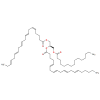

In [18]:
tag = list(lm.get_obmol('TAG(15:0_20:4_20:5)', 'synonym'))[0]
tag

### 2: Lipid name parser

In [19]:
from lipyd import name

In [20]:
nameproc = name.LipidNameProcessor(database = 'swisslipids', iso = True)

In [22]:
nameproc.process(['Phosphatidylethanolamine (16:0/20:4(5Z,8Z,11Z,14Z))'])

(Headgroup(main='PE', sub=('',)),
 Chain(c=36, u=4, typ=None, attr=ChainAttr(sph='', ether=False, oh=()), iso=()),
 (Chain(c=16, u=0, typ='FA', attr=ChainAttr(sph='', ether=False, oh=()), iso=()),
  Chain(c=20, u=4, typ='FA', attr=ChainAttr(sph='', ether=False, oh=()), iso=('5Z', '8Z', '11Z', '14Z'))))

In [27]:
nameproc.process(['octadecanoate'])

(Headgroup(main='FA', sub=()),
 Chain(c=18, u=0, typ=None, attr=ChainAttr(sph='', ether=False, oh=()), iso=()),
 [Chain(c=18, u=0, typ='FA', attr=ChainAttr(sph='', ether=False, oh=()), iso=())])

### 3: Classes representing metabolites

In [28]:
from lipyd import lipid

In [29]:
pe = list(lipid.EtherPE(fa_args = {'c': 16, 'u': 1}, sn2_fa_args = {'c': 28, 'u': 0}))[0]

In [31]:
pe.name, pe.mass

('PE(O-16:1/28:0)', 843.70809150558)

In [32]:
lipid.EtherPE(fa_args = {'c': 16, 'u': 1}, sn2_fa_args = {'c': 28, 'u': 0}).subs

### 4: MS2 fragment database

In [36]:
from lipyd import fragdb

In [55]:
imp.reload(fragdb)
fragdb.init_db('neg')
fragdb.init_db('pos')
fragdb.lookup_neg(283.26)

7171

### 5: MS2 spectrum analysis

In [39]:
from lipyd import ms2
from lipyd import settings
from lipyd import mgf

In [40]:
mgffile = settings.get('mgf_example')
mgfreader = mgf.MgfReader(mgffile, label = 'F07')

In [42]:
precursor = mgfreader.mgfindex[777, 0]
idx, rtdiff = mgfreader.lookup(precursor)

In [43]:
scan = mgfreader.get_scan(idx[33])